### Run this if spectral needs to be installed

In [1]:
# import sys
# !{sys.executable} -m pip install spectral

## Following tutorial found at
https://eufat.github.io/2019/02/19/hyperspectral-image-preprocessing-with-python.html

In [34]:
# imports

from spectral import imshow, view_cube
import spectral.io.envi as envi
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
from numpy.polynomial import Polynomial, polynomial

# https://doi.org/10.1063/5.0019847 imports
import algorithm.generate_spectrum as gs
from algorithm.pixel_operations import choose_pixels, generate_combinations
from algorithm.temperature_functions import optimum_temperature
from algorithm.kfold import order_selection
from scipy.interpolate import splrep, splev, UnivariateSpline

# constants
h = 6.626e-34 # Planck's constant
c = 299792458 # Speed of light
k = 1.380649e-23 # Boltzmann constant
b = 2.89777e-3 # Wien's displacement law constant

Using the spectral package, we load the hyperspectral data into a 3-dimensional numpy array as is a matrix of spectra.

In [3]:
# opening the raw data from its ENVI file and header

data_ref = envi.open('raw.hdr', 'raw.raw')
print(type(data_ref))
print()
print(data_ref)

<class 'spectral.io.bilfile.BilFile'>

	Data Source:   './raw.raw'
	# Rows:           1562
	# Samples:        1600
	# Bands:           371
	Interleave:        BIL
	Quantization:  16 bits
	Data format:    uint16


Need to figure out what wavelengths the 371 bands are so we can plot data against the wavelength values. Below is this process on an arbitrary hyperspectral image.

In [4]:
# converting the data to a tensor as a NumPy array

data_tensor = np.array(data_ref.load())
print(type(data_tensor))
shape = data_tensor.shape
print(f"Tensor dimensions = {shape}")
print()
print(data_tensor)

<class 'numpy.ndarray'>
Tensor dimensions = (1562, 1600, 371)

[[[ 348.  358.  470. ... 1701. 1677. 1756.]
  [ 348.  358.  470. ... 1601. 1589. 1724.]
  [ 312.  328.  420. ... 1689. 1591. 1571.]
  ...
  [  81.   73.   98. ...  371.  370.  461.]
  [ 108.   85.   86. ...  339.  410.  415.]
  [  78.  101.   82. ...  428.  408.  421.]]

 [[ 363.  374.  445. ... 1696. 1762. 1667.]
  [ 363.  374.  445. ... 1611. 1505. 1543.]
  [ 284.  376.  444. ... 1619. 1554. 1684.]
  ...
  [  94.   82.   96. ...  422.  442.  431.]
  [  82.   92.  103. ...  413.  366.  389.]
  [  81.  115.   79. ...  382.  387.  409.]]

 [[ 343.  360.  379. ... 1751. 1625. 1649.]
  [ 343.  360.  379. ... 1631. 1827. 1623.]
  [ 368.  395.  411. ... 1759. 1626. 1582.]
  ...
  [  93.   89.  109. ...  423.  385.  395.]
  [ 107.   85.   98. ...  431.  423.  433.]
  [  76.  103.   97. ...  458.  434.  406.]]

 ...

 [[ 341.  373.  471. ... 1735. 1681. 1774.]
  [ 341.  373.  471. ... 1728. 1608. 1640.]
  [ 316.  338.  432. ... 17

<Figure size 432x288 with 0 Axes>

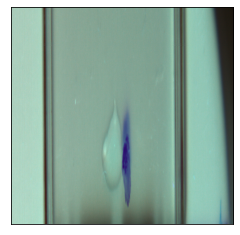

In [5]:
# displaying tensor as an image -- the colors don't present the same as the png

plt.figure()
imshow(data_tensor)
plt.xticks([])
plt.yticks([])
plt.show()

<Figure size 720x720 with 0 Axes>

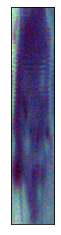

In [6]:
plt.figure(figsize=(10,10))
imshow(data_tensor[1000:1200,800:840,:])
plt.xticks([])
plt.yticks([])
plt.show()

Below, we can select individual pixels in the image and plot their spectra.

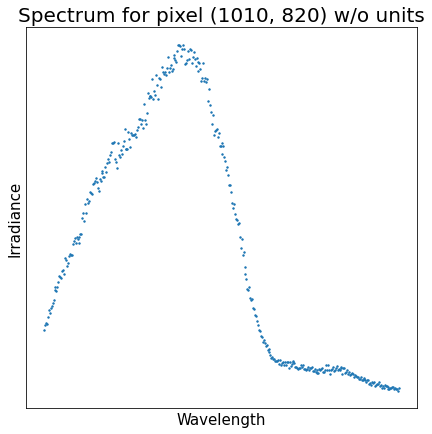

In [7]:
plt.figure(figsize=(7,7))
plt.scatter(np.arange(371), data_tensor[1010][820][::-1], s=2)
plt.title("Spectrum for pixel (1010, 820) w/o units", fontsize=20)
plt.xlabel("Wavelength", fontsize=15)
plt.ylabel("Irradiance", fontsize=15)
plt.xticks([])
plt.yticks([])
plt.show()

## Parsing hdr file for wavelength bands
Each hyperspectral image has a header file containing meta-data. Most relevant are the wavelength values at which the spectra are measured.

In [8]:
# reading hdr file

file = open("raw.hdr", 'r')
text = file.read()
print(text)

ENVI
description = {[HEADWALL Hyperspec III]}
samples = 1600
lines = 1562
bands = 371
header offset = 0
file type = ENVI Standard
data type = 12
interleave = bil
sensor type = Unknown
default bands = {191,86,50}
byte order = 0
wavelength units = nm
wavelength = {
399.471
,401.098
,402.725
,404.351
,405.978
,407.605
,409.232
,410.858
,412.485
,414.112
,415.738
,417.365
,418.992
,420.619
,422.245
,423.872
,425.499
,427.126
,428.752
,430.379
,432.006
,433.633
,435.259
,436.886
,438.513
,440.14
,441.766
,443.393
,445.02
,446.647
,448.273
,449.9
,451.527
,453.153
,454.78
,456.407
,458.034
,459.66
,461.287
,462.914
,464.541
,466.167
,467.794
,469.421
,471.048
,472.674
,474.301
,475.928
,477.555
,479.181
,480.808
,482.435
,484.062
,485.688
,487.315
,488.942
,490.569
,492.195
,493.822
,495.449
,497.075
,498.702
,500.329
,501.956
,503.582
,505.209
,506.836
,508.463
,510.089
,511.716
,513.343
,514.97
,516.596
,518.223
,519.85
,521.477
,523.103
,524.73
,526.357
,527.984
,529.61
,531.237
,532.864


In [9]:
# parsing for wavelength values and units

start_id = "\nwavelength = {\n"
start_index = text.find(start_id) + len(start_id)
end_id = "\n}\n;AOI height"
end_index = text.find(end_id)
wavelengths = text[start_index:end_index]
wavelengths_arr = np.array(wavelengths.split("\n,"), dtype="float32")
print(wavelengths_arr)

units_id = "wavelength units = "
units_index = text.find(units_id) + len(units_id)
units = text[units_index:text.find(start_id)]
print(f"Units = {units}")

[ 399.471  401.098  402.725  404.351  405.978  407.605  409.232  410.858
  412.485  414.112  415.738  417.365  418.992  420.619  422.245  423.872
  425.499  427.126  428.752  430.379  432.006  433.633  435.259  436.886
  438.513  440.14   441.766  443.393  445.02   446.647  448.273  449.9
  451.527  453.153  454.78   456.407  458.034  459.66   461.287  462.914
  464.541  466.167  467.794  469.421  471.048  472.674  474.301  475.928
  477.555  479.181  480.808  482.435  484.062  485.688  487.315  488.942
  490.569  492.195  493.822  495.449  497.075  498.702  500.329  501.956
  503.582  505.209  506.836  508.463  510.089  511.716  513.343  514.97
  516.596  518.223  519.85   521.477  523.103  524.73   526.357  527.984
  529.61   531.237  532.864  534.491  536.117  537.744  539.371  540.997
  542.624  544.251  545.878  547.504  549.131  550.758  552.385  554.011
  555.638  557.265  558.892  560.518  562.145  563.772  565.399  567.025
  568.652  570.279  571.906  573.532  575.159  576.786

In [10]:
len(wavelengths_arr)

371

In [11]:
np.max(wavelengths_arr) / np.min(wavelengths_arr)

2.506715

The method provided in the paper (doi: 10.1063/5.0019847) has maximum precision when the ratio of maximum to minimum wavelength is 2.46, which would make it extremely effective for this imaging.

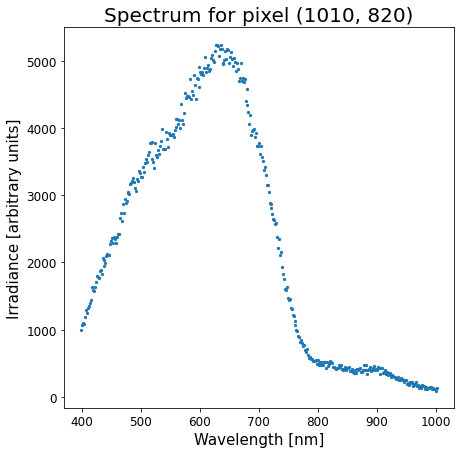

In [12]:
plt.figure(figsize=(7,7))
plt.scatter(wavelengths_arr, data_tensor[1010][820][::-1], s=5)
plt.title("Spectrum for pixel (1010, 820)", fontsize=20)
plt.xlabel(f"Wavelength [{units}]", fontsize=15)
plt.ylabel("Irradiance [arbitrary units]", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Fitting spectrum to blackbody radiation curve to find temperature and emissivity
### Using Machine Learning -- assumes wavelength independent emissivity
This is a direct attempt at curve_fitting

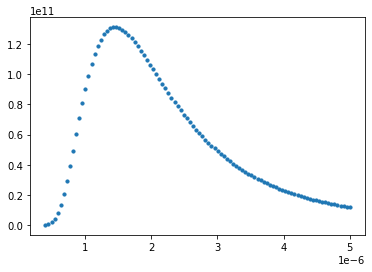

In [13]:
# l: wavelength, T: temperature, e: emissivity
def blackbody(l, T, e):
    return e * ((2 * h * c**2) / l**5) * (1 / (np.exp((h * c) / (l * k * T)) - 1))

x = np.linspace(400e-9, 5000e-9, num=100)
y = np.array([blackbody(i, 2000, 1) for i in x])
plt.scatter(x, y, s=10)

In [14]:
xdata = [w * 1e-9 for w in wavelengths_arr] # convert nanometers to meters
ydata = data_tensor[1010][820][::-1]
p0 = [298, 0.5]
popt, pcov = curve_fit(blackbody, xdata, ydata, p0)
print(popt)

[328.00018495   0.63177159]


In [15]:
print(f"Temperature = {popt[0]}\nEmissivity = {popt[1]}\n")
print(f"Covariance matrix for (Temperature, Emissivity):\n{pcov}\n")
print(f"One standard deviation errors for (Temperature, Emissivity):\n{np.sqrt(np.diag(pcov))}")

Temperature = 328.0001849471762
Emissivity = 0.6317715904067478

Covariance matrix for (Temperature, Emissivity):
[[ 1.29364421e+19 -8.99531651e+17]
 [-8.99531651e+17  7.03187245e+16]]

One standard deviation errors for (Temperature, Emissivity):
[3.59672659e+09 2.65176780e+08]


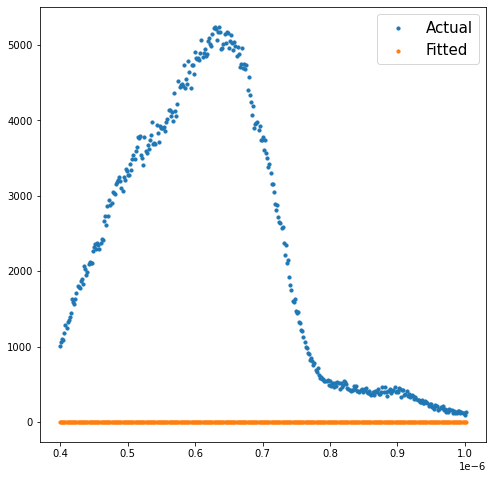

In [16]:
yfit = np.array([blackbody(w, popt[0], popt[1]) for w in xdata])
plt.figure(figsize=(8,8))
plt.scatter(xdata, ydata, s=10)
plt.scatter(xdata, yfit, s=10)
plt.legend(["Actual", "Fitted"], fontsize=15)
plt.show()

This fit did not work, but could it be due to bad initial guess or the sample not having been a blackbody.

### Directly from blackbody physics -- will not work for non blackbodies
For a heated sample in the LDFZ, reflection from the lasers should be negligible in comparison to the blackbody radiation from the sample. So, we can assume a blackbody and directly use blackbody physics.

The equation for intensity of blackbody radiation is $$ I(\lambda, T) = \epsilon(\lambda, T) \left( \frac{2hc^2}{\lambda^5} \right) \left( \exp{\left( \frac{hc}{\lambda k_BT} \right)} - 1 \right)^{-1} $$ We know from Wien's displacement law that $$\lambda_{\max} = \frac{b}{T}$$ Given a blackbody spectrum from a sample pixel, we can then determine the temperature by finding the wavelength of maximum emission and applying Wien's displacement law. With a known temperature, we can use the blackbody radiation equation to determine the emissivity at each wavelength. We could additionally then fit the emissivity as a function of wavelength using a Taylor series model. Previous work suggests that a second-degree polynomial suffices for metals (DOI: 10.1103/PhysRevApplied.14.014031, page 3).

In [17]:
def blackbody_solve(wavelengths, intensities):
    assert(len(wavelengths) == len(intensities))
    
    # Get temperature with Wien's displacement law
    l_max = wavelengths[list(intensities).index(np.max(intensities))] * 1e-9 # assuming nm, convert to m
    T = b / l_max
    
    emissivities = []
    for i in range(len(wavelengths)):
        l, I = wavelengths[i] * 1e-9, intensities[i]
        e = I * (l**5 / (2 * h * c**2)) * (np.e**((h * c) / (l * k * T)) - 1)
        emissivities.append(e)
        
    return T, emissivities

Temperature = 4608.112359482947


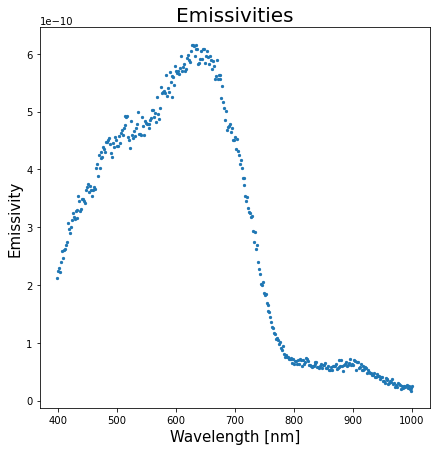

In [18]:
T, es = blackbody_solve(wavelengths_arr, data_tensor[1010][820][::-1])
print(f"Temperature = {T}")
plt.figure(figsize=(7,7))
plt.scatter(wavelengths_arr, es, s=5)
plt.title("Emissivities", fontsize=20)
plt.xlabel("Wavelength [nm]", fontsize=15)
plt.ylabel("Emissivity", fontsize=15)
plt.show()

In [19]:
def makeBlackbody(T, emissivities, wavelengths):
    assert(len(wavelengths) == len(emissivities))
    
    intensities = []
    for i in range(len(wavelengths)):
        l, e = wavelengths[i] * 1e-9, emissivities[i]
        intensities.append(blackbody(l, T, e))
        
    return intensities

intensities_calculated = makeBlackbody(T, es, wavelengths_arr)

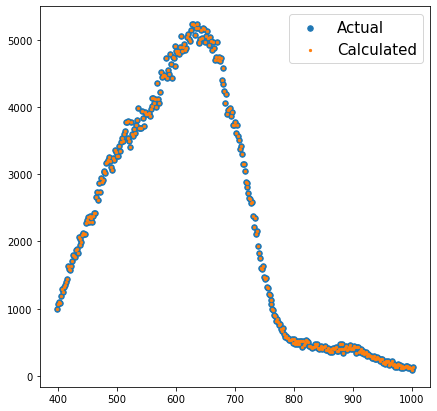

In [20]:
plt.figure(figsize=(7,7))
plt.scatter(wavelengths_arr, data_tensor[1010][820][::-1], s=30)
plt.scatter(wavelengths_arr, intensities_calculated, s=5)
plt.legend(["Actual", "Calculated"], fontsize=15)
plt.show()

Note that this will always create a perfect fit since the emissivities are exactly calculated, but whether this is accurate relies on the sample obeying the blackbody equations. The above sample is likely not at 4608 K, but it is also likely not a blackbody as it would not have been imaged by hand outside a furnace while glowing substantially.

### Non-linear least squares -- not assuming emissivity independent of wavelength
For this, we need to assume some model of emissivity's wavelength dependence. Using the second-degree polynomial mentioned above, we can model emissivity with $$\epsilon(\lambda) = a_0 + a_1\lambda + a_2\lambda^2$$ Substituting this into the equation for blackbody radiation intensity gives $$I(\lambda) = (a_0 + a_1\lambda + a_2\lambda^2) \left( \frac{2hc^2}{\lambda^5} \right) \left( \exp{\left( \frac{hc}{\lambda k_B T} \right) - 1} \right)^{-1}$$ where we have intensity as a function of wavelength with fitting parameters $a_0, a_1, a_2, T$. We can then fit this model using non-linear least squares regression

In [21]:
# params = [a0, a1, a2, T]
def intensity(params, l):
    e = params[0] + (params[1] * l) + (params[2] * l**2)
    return blackbody(l, params[3], e)
        
def residuals(params):
    result = []
    for i in range(len(wavelengths_arr)):
        Si = intensity(params, wavelengths_arr[i] * 1e-9)
        St = data_tensor[1010][820][::-1][i]
        result.append(Si - St)
    return np.array(result)
    
params0 = np.array([1, 1, 1, 298])
result = least_squares(residuals, params0)
print(f"Optimal parameters: {result.x}\nFinal Cost: {result.cost}\nTermination Status: {result.status}")

Optimal parameters: [ 1.93634464e-07 -4.27261957e-01  2.35274601e+05  2.69809038e+03]
Final Cost: 38311047.581258565
Termination Status: 2


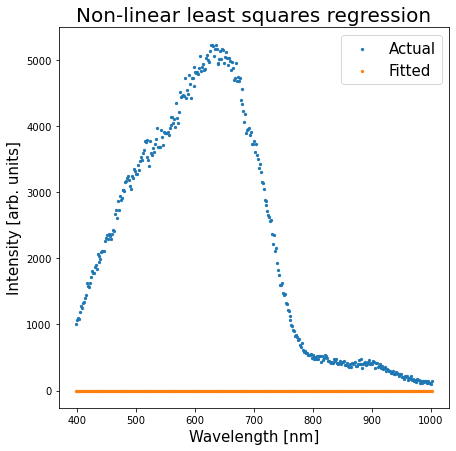

In [22]:
yfit = []
for l in wavelengths_arr:
    yfit.append(intensity(result.x, l))
    
plt.figure(figsize=(7,7))
plt.scatter(wavelengths_arr, data_tensor[1010][820][::-1], s=5)
plt.scatter(wavelengths_arr, yfit, s=5)
plt.title("Non-linear least squares regression", fontsize=20)
plt.xlabel("Wavelength [nm]", fontsize=15)
plt.ylabel("Intensity [arb. units]", fontsize=15)
plt.legend(["Actual", "Fitted"], fontsize=15)
plt.show()

In [23]:
# params = [a0, a1, a2, T]
def intensity(params, l):
    e = params[0] + (params[1] * l) + (params[2] * l**2)
    return blackbody(l, params[3], e)
        
# exact blackbody with noise
St_full = []
for l in wavelengths_arr:
    St_full.append(blackbody(l * 1e-9, 3000, 0.5) + np.random.normal(0, 0.1e11))

def residuals(params):
    result = []
    for i in range(len(wavelengths_arr)):
        Si = intensity(params, wavelengths_arr[i] * 1e-9)
        St = St_full[i]
        result.append(Si - St)
    return np.array(result)
    
params0 = np.array([1, 1, 1, 1000])
result = least_squares(residuals, params0)
print(f"Optimal parameters: {result.x}")

Optimal parameters: [ 5.69505078e-01 -4.78805918e+04  7.62548944e+04  2.96996585e+03]


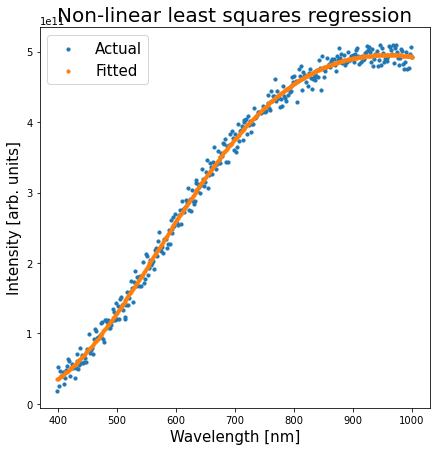

In [24]:
yfit = []
for l in wavelengths_arr:
    yfit.append(intensity(result.x, l * 1e-9))
    
plt.figure(figsize=(7,7))
plt.scatter(wavelengths_arr, St_full, s=10)
plt.scatter(wavelengths_arr, yfit, s=10)
plt.title("Non-linear least squares regression", fontsize=20)
plt.xlabel("Wavelength [nm]", fontsize=15)
plt.ylabel("Intensity [arb. units]", fontsize=15)
plt.legend(["Actual", "Fitted"], fontsize=15)
plt.show()

For a blackbody spectrum with emissivity independent of wavelength, this method is able to accurately fit the spectrum and find the parameters. It should also be able to fit an emissivity dependent on wavelength. If the fit is not great, the model for emissivity can be extended to a higher order Taylor series. Note that the initial guess for temperature needs to be on the order of the actual temperature.

### K-fold cross-validation from https://doi.org/10.1063/5.0019847
### Duvaut 1995 Example
This paper supplies code that fits the spectrum similar to the previous method, but does not require a model for emissivity to be pre-selected. Instead, this method selects the polynomial order of the emissivity as a function of wavelength as part of the fitting.

593.1100394864451 573 3.509605495016595


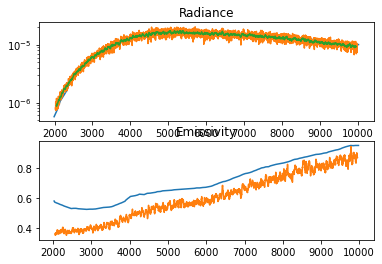

In [25]:
### Emissivity functions
# Black and gray body
bb_eps = lambda wl,T: 1.0 * np.ones(len(wl))
gr_eps = lambda wl,T: 0.1 * np.ones(len(wl))

# Emissivity from Duvaut; same method: generate radiance from emissivity
data = np.genfromtxt('data/duvaut-1995/tantalum-emissivity.csv', delimiter=',',skip_header=1)
eps_xp = data[:,1]
wl_eps_xp = data[:,0] * 1000 # Wavelengths are in micro-meter
T = 573
Ttrue = T

# Spline the data to generate the "true" emissivity
eps_spl = splrep(wl_eps_xp,eps_xp)
f_eps = lambda wl,T: splev(wl,eps_spl)

#### Vectors of pixels and wavelengths
wl_vec = np.linspace(np.min(wl_eps_xp),np.max(wl_eps_xp),(int)(3000))
pix_vec = np.linspace(0,2999,3000)
pix_vec = np.array(pix_vec,dtype=np.int64)


### Generate some data
I_calc,noisy_data,filtered_data,data_spl,pix_sub_vec = gs.generate_data(
        wl_vec,T,pix_vec,f_eps)
wl_sub_vec = wl_vec[pix_sub_vec]


### Choose the order of the emissivity w/ k-fold
poly_order = order_selection(data_spl,
                       pix_sub_vec,wl_vec,
                       bb_eps)

### Calculate the temperature using the whole dataset
# Pixel operations
chosen_pix = choose_pixels(pix_sub_vec,bin_method='average')
cmb_pix = generate_combinations(chosen_pix,pix_sub_vec)

# Compute the temperature
Tave, Tstd, Tmetric, sol = optimum_temperature(data_spl,cmb_pix,
                                            pix_sub_vec,wl_vec,
                                            poly_order)

### Reconstruct data
bb_reconstructed = gs.wien_approximation(wl_sub_vec,Tave,bb_eps)
eps_vec_reconstructed = np.exp(filtered_data)/bb_reconstructed
# Since we get epsilon from the filtered data, "reconstructed_data" will be
# exactly like "filtered_data"
reconstructed_data = bb_reconstructed * eps_vec_reconstructed # exactly filtered   

# Alternative using the polynomial from optimization
reconstructed_alt = gs.wien_approximation(wl_sub_vec,Tave,bb_eps)
wl_min = np.min(wl_sub_vec)
wl_max = np.max(wl_sub_vec)

if poly_order > 0:
    cheb = Polynomial(sol.x,[wl_min,wl_max])
    eps_vec = polynomial.polyval(wl_sub_vec,cheb.coef)
    
else:
    eps_ave = np.average(eps_vec_reconstructed)
    eps_vec = eps_ave * np.ones(len(wl_sub_vec))
    
reconstructed_alt *= eps_vec


#### Plots
data = np.genfromtxt('data/duvaut-1995/tantalum-irradiance.csv', delimiter=',',skip_header=1)
radiance = data[:,1] / 1e7
wl_vec_radiance = data[:,0] * 1000 # Wavelengths are in micro-meter

fig, ax = plt.subplots(2,1)
ax[0].semilogy(wl_vec_radiance,radiance)
ax[0].semilogy(wl_vec,noisy_data)
ax[0].semilogy(wl_sub_vec,reconstructed_data)
ax[0].set_title("Radiance")

ax[1].plot(wl_eps_xp,eps_xp)
ax[1].plot(wl_sub_vec,eps_vec_reconstructed)
ax[1].set_title("Emissivity")

error = np.abs((Tave-Ttrue)/Ttrue)*100
print(Tave,Ttrue,error)

Modifying for our use

In [26]:
bb_eps = lambda wl,Temp: 1.0 * np.ones(len(wl))

# Irradiance data
data = np.genfromtxt("data/Duvaut-1995/tantalum-irradiance.csv", delimiter=",", skip_header=1)

# Vectors of pixels and wavelengths
# wl_vec = np.linspace(np.min(data[:,0]),np.max(data[:,0]),(int)(3000))
wl_vec = data[:,0]
# pix_vec = np.linspace(0, 2999, 3000)
pix_vec = np.linspace(0,len(wl_vec)-1,len(wl_vec))
pix_vec = np.array(pix_vec, dtype=np.int64)

# Spline data
data_spl = splrep(data[:,0], data[:,1])

In [27]:
# Choose the order of the emissivity w/ k-fold
poly_order = order_selection(data_spl,pix_vec,wl_vec,bb_eps)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
### Calculate the temperature using the whole dataset
# Pixel operations
chosen_pix = choose_pixels(pix_vec,bin_method='average')
cmb_pix = generate_combinations(chosen_pix,pix_vec)

# Compute the temperature
Tave, Tstd, Tmetric, sol = optimum_temperature(data_spl,cmb_pix,
                                            pix_vec,wl_vec,
                                            poly_order)

In [ ]:
print(Tave, Tstd)

### Araujo 2020 Example

In [35]:
'''
Note: this emissivity tests the limits of the algorithm. The emissivity may
not be recovered correctly (values >1) and temperature error may go up to 8%.
To mitigate that, the value of window_length should be changed to a lower 
value (11 seems ok). Other parameters can be changed as well, such as the 
number of k-folds (lower down to 5).  
'''

def araujo_emissivity(esp,espp,c,r,lmin,lmax,wl):
    xi = r/(lmax-lmin)
    
    l0 = (1-c) * lmin + c * lmax
    
    xp = 1 + np.exp(-xi * (lmin-l0))
    xpp = 1 + np.exp(-xi * (lmax-l0))
    
    deps = (espp-esp) / (1/xpp-1/xp)
    eps0 = (xpp * espp - xp * esp)  / (xpp-xp)
    
    eps = eps0 + deps / (1+np.exp(-xi*(wl-l0)))
    
    return eps
        

# Black and gray body
bb_eps = lambda wl,T: 1.0 * np.ones(len(wl))
# gr_eps = lambda wl,T: 0.5 * np.ones(len(wl))

### Generate some data
T = 1000 # K

# First create the emissivity
lambda_min = 0.4 * 1e3
lambda_max = 0.8 * 1e3

# Parameters
Nwl = 3000 # 3000 wavelengths
wl_vec = np.linspace(lambda_min,lambda_max,Nwl)

pix_vec = np.linspace(0,len(wl_vec)-1,len(wl_vec))
pix_vec = np.array(pix_vec,dtype=np.int64)

# Radiance
eps1 = lambda wl,T: araujo_emissivity(0.3,0.9,1,4,lambda_min,lambda_max,wl)
eps2 = lambda wl,T: araujo_emissivity(0.9,0.3,0.7,20,lambda_min,lambda_max,wl)

noise = False

if noise:
    I_calc,noisy_data,filtered_data,data_spl,pix_sub_vec = gs.generate_data(
            wl_vec,T,pix_vec,eps2)
    
else:
    I_calc = gs.wien_approximation(wl_vec,T,eps2)
    noisy_data = np.copy(I_calc)
    
    # Take the log of the data
    
    log_noisy = np.log(noisy_data)
    
    wl_vec_sub = np.copy(wl_vec)
    log_med = np.copy(log_noisy)
    pix_vec_sub = np.copy(pix_vec)
    
    ### Fit a spline to access data easily
    data_spl = splrep(wl_vec_sub,log_med)
    
    pix_sub_vec = np.copy(pix_vec_sub)
    filtered_data = np.copy(log_med)


#I_calc,noisy_data,filtered_data,data_spl,pix_sub_vec = gs.generate_data(
#        wl_vec,T,pix_vec,f_eps,el)
wl_sub_vec = wl_vec[pix_sub_vec]

### Choose the order of the emissivity w/ k-fold
poly_order = order_selection(data_spl,
                       pix_sub_vec,wl_vec,
                       bb_eps)

### Calculate the temperature using the whole dataset
# Pixel operations
chosen_pix = choose_pixels(pix_sub_vec,bin_method='average')
cmb_pix = generate_combinations(chosen_pix,pix_sub_vec)

# Compute the temperature
Tave, Tstd, Tmetric, sol = optimum_temperature(data_spl,cmb_pix,
                                            pix_sub_vec,wl_vec,
                                            poly_order)

### Reconstruct data
bb_reconstructed = gs.wien_approximation(wl_sub_vec,Tave,bb_eps)
#eps_vec_reconstructed = 10**filtered_data/bb_reconstructed
eps_vec_reconstructed = np.exp(filtered_data)/bb_reconstructed
# Since we get epsilon from the filtered data, "reconstructed_data" will be
# exactly like "filtered_data"
reconstructed_data = bb_reconstructed * eps_vec_reconstructed # exactly filtered   

# Alternative using the polynomial from optimization
reconstructed_alt = gs.wien_approximation(wl_sub_vec,Tave,bb_eps)
wl_min = np.min(wl_sub_vec)
wl_max = np.max(wl_sub_vec)

if poly_order > 0:
    cheb = Polynomial(sol.x,[wl_min,wl_max])
    eps_vec = polynomial.polyval(wl_sub_vec,cheb.coef)
    
else:
    eps_ave = np.average(eps_vec_reconstructed)
    eps_vec = eps_ave * np.ones(len(wl_sub_vec))
    
reconstructed_alt *= eps_vec


#### Plots
fig, ax = plt.subplots(2,1)
ax[0].semilogy(wl_vec,noisy_data)
ax[0].semilogy(wl_sub_vec,reconstructed_data)

ax[1].plot(wl_vec,eps2(wl_vec,T))
ax[1].plot(wl_sub_vec,eps_vec_reconstructed)

error = np.abs((Tave-T)/T)*100

print(Tave,error,poly_order)

/Users/namanparikh/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [117]:
wl_vec = np.linspace(3000, 8000, 3000)

# blackbody with noise
I = []
for l in wl_vec:
    I.append((blackbody(l * 1e-9, 500, 0.5) + np.random.normal(0, 0.1e11)) * 1e7)
    if I[-1] <= 0:
        I[-1] = 1e-9

In [118]:
# Black and gray body
bb_eps = lambda wl,T: 1.0 * np.ones(len(wl))

pix_vec = np.linspace(0,len(wl_vec)-1,len(wl_vec))
pix_vec = np.array(pix_vec,dtype=np.int64)

noisy_data = np.copy(I)
    
# Take the log of the data

log_noisy = np.log(noisy_data)

wl_vec_sub = np.copy(wl_vec)
log_med = np.copy(log_noisy)
pix_vec_sub = np.copy(pix_vec)

### Fit a spline to access data easily
data_spl = splrep(wl_vec_sub,log_med)

pix_sub_vec = np.copy(pix_vec_sub)
filtered_data = np.copy(log_med)

wl_sub_vec = wl_vec[pix_sub_vec]

In [119]:
### Choose the order of the emissivity w/ k-fold
poly_order = order_selection(data_spl,
                       pix_sub_vec,wl_vec,
                       bb_eps)

In [120]:
poly_order

0

In [121]:
### Calculate the temperature using the whole dataset
# Pixel operations
chosen_pix = choose_pixels(pix_sub_vec,bin_method='average')
cmb_pix = generate_combinations(chosen_pix,pix_sub_vec)

# Compute the temperature
Tave, Tstd, Tmetric, sol = optimum_temperature(data_spl,cmb_pix,
                                            pix_sub_vec,wl_vec,
                                            poly_order)

In [122]:
Tave, Tstd

(192.64147314268493, 977.5784365089434)